In [84]:
import copy
import random
from types import SimpleNamespace
from typing import List
import pandas as pd
import vrplib

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxIterations

from myvrplib import plot_solution, plot_data, verify_time_windows
from data_module import data, END_OF_DAY
from route import Route
from vrpstates import CvrptwState
from initial_solutions.initial_solutions import nearest_neighbor_tw
from operators.destroy import *
from operators.repair import *

In [85]:
%matplotlib inline
SEED = 1234
from myvrplib import END_OF_DAY

In [86]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR)

# Implementation of wang 2024
https://www.sciencedirect.com/science/article/pii/S0360835224002432?via%3Dihub

NOTE: data['dimension'] is the number of customers only, not including depots

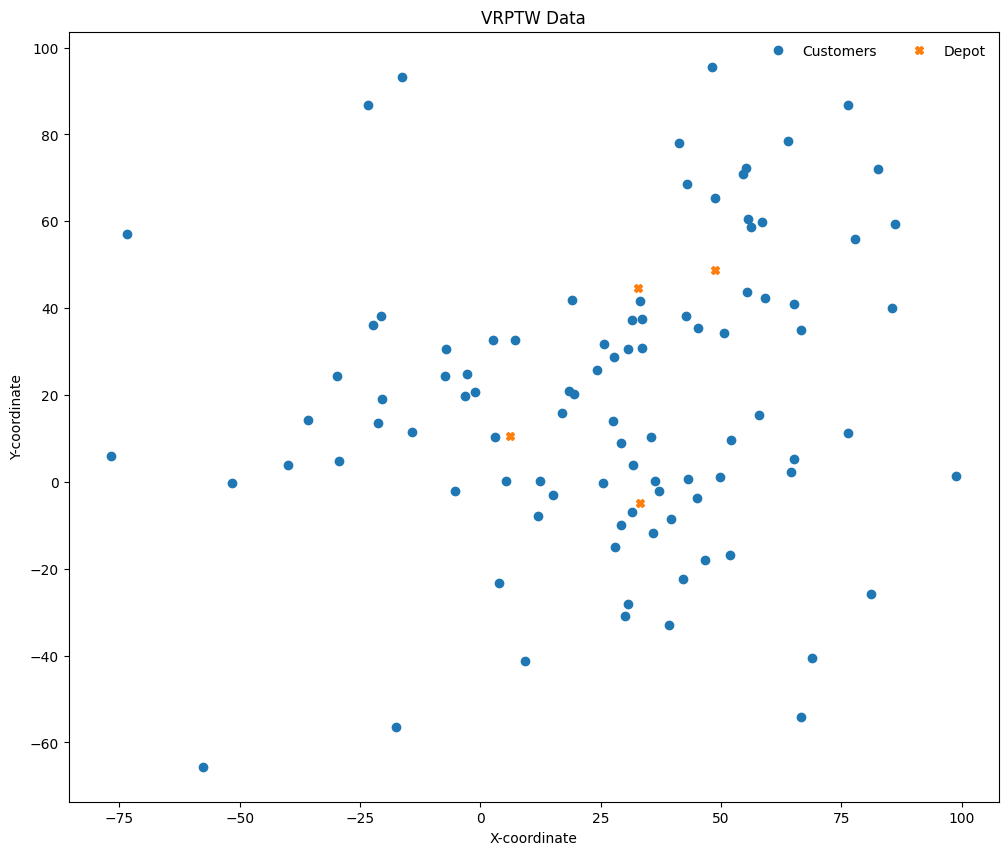

In [87]:
plot_data(data)

## Solution state

In [88]:
def get_customer_info(data, state: CvrptwState, idx):
    """
    Get the customer information for the passed-in index.
    """
    route = state.find_route(idx)
    index_in_route = state.find_index_in_route(idx, route)
    route_index = state.routes.index(route)
    print(f"index_in_route: {index_in_route}")
    print(f"route: {route}")
    planned_service_time = state.times[route_index][index_in_route]

    dict = {
        "index": idx,
        "coords": data["node_coord"][idx],
        "demand": data["demand"][idx].item(),
        "ready time": data["time_window"][idx, 0].item(),
        "due time": data["time_window"][idx, 1].item(),
        "service_time": data["service_time"][idx].item(),
        "route": route,
        "planned service time": planned_service_time,
    }

    return dict

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [89]:
degree_of_destruction = 0.05
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)
print(f"Removing {customers_to_remove} customers.")

Removing 4 customers.


## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost. Time window constraints are implemented as follows in the **greedy repair**:

1)  Within the set of unvisited nodes, first find those nodes that can be visited within the node's time window from the current end of each existing route
2)  Add the node that is nearest to the end of some route to that route
3)  If no unvisited nodes can be visited on time, make a new route just for that node

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

### Choosing starting depot
If the number of vehicles if larger than number of depots we split the number of vehicles between the depots.

Otherwise, we choose randomly a depot and generate a route from it.
NOTE: maybe performance of the model can be improved by changing the above policy

In [90]:
# calculate_depots(data)
print(data['depot_to_vehicles'])
print(data['vehicle_to_depot'])
print(data['dimension'])

{96: [1], 97: [0], 98: [], 99: [2]}
{0: 97, 1: 96, 2: 99}
96


In [91]:
print(data['depots'])

[96, 97, 98, 99]


Unvisited customers: {1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 17, 18, 19, 22, 23, 24, 26, 29, 30, 33, 34, 37, 38, 39, 40, 42, 45, 47, 48, 49, 50, 52, 54, 59, 62, 63, 66, 67, 71, 73, 74, 75, 76, 79, 81, 82, 85, 89, 90, 91, 92}


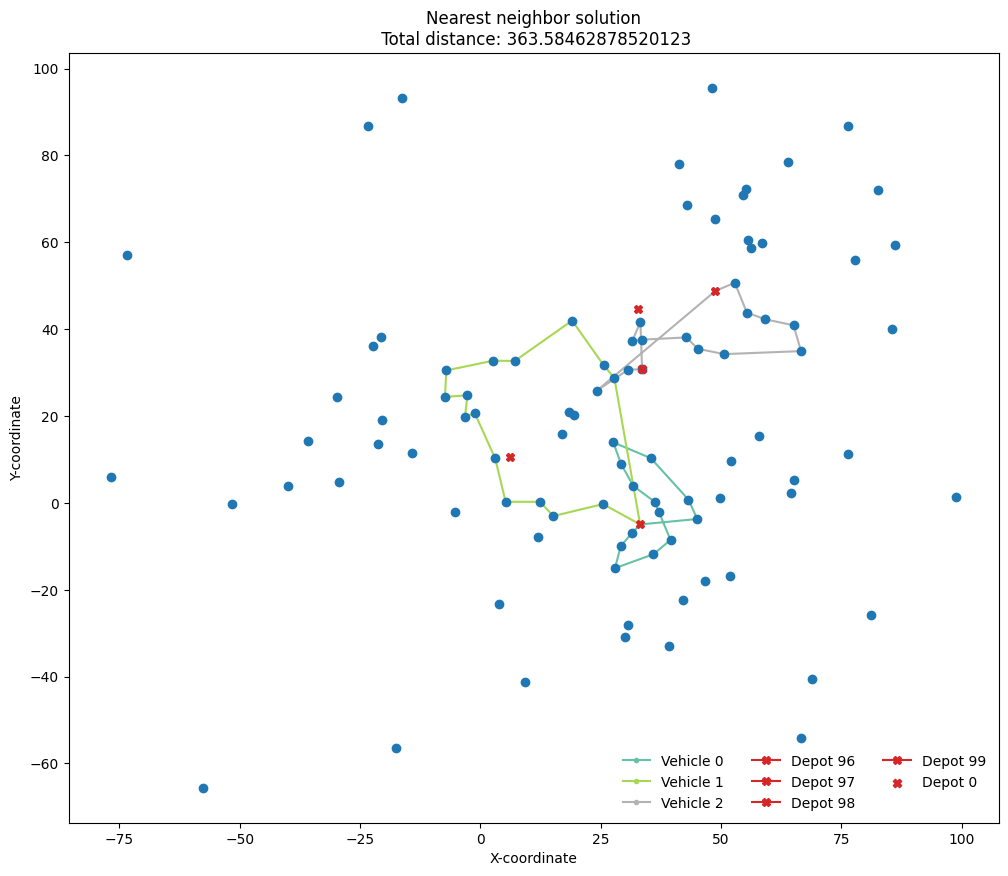

In [92]:
initial_solution = nearest_neighbor_tw()

plot_solution(data, initial_solution, "Nearest neighbor solution")

In [93]:
for route in initial_solution.routes:
    print(route.customers_list)

[99, 88, 51, 60, 44, 78, 10, 27, 53, 28, 94, 56, 20, 25, 99]
[99, 57, 69, 58, 83, 80, 72, 61, 36, 43, 16, 68, 8, 93, 31, 64, 99]
[98, 95, 55, 65, 35, 70, 84, 21, 41, 87, 32, 77, 0, 46, 86, 98]


In [94]:
late, early, ontime, left_out = verify_time_windows(data, initial_solution)
print(f"Late: {late}, Early: {early}, Ontime: {ontime}")
print(f"Left out customers because of not enough routes/vehicles: {left_out}")

Late: 0, Early: 42, Ontime: 0
Left out customers because of not enough routes/vehicles: 54


## Heuristic solution

Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we do not actually use any adaptive operator selection -- but you can easily add more destroy and repair operators. 

In [95]:
alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(random_route_removal)
alns.add_destroy_operator(cost_reducing_removal)
# alns.add_destroy_operator(shaw_removal)

alns.add_repair_operator(greedy_repair)

In [96]:
num_iterations = 2000
init = nearest_neighbor_tw()
select = RouletteWheel([25, 5, 1, 0], 0.8, 3, 1)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)
result = alns.iterate(init, select, accept, stop)

Unvisited customers: {1, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 26, 29, 30, 31, 33, 34, 36, 37, 38, 39, 42, 43, 45, 47, 48, 54, 61, 62, 63, 66, 67, 68, 72, 73, 74, 76, 79, 81, 82, 85, 89, 90, 91, 92, 93, 95}
Starting iteration 0.
Starting iteration 1.
Starting iteration 2.
Solution does not contain customer 49.
Solution does not contain customer 82.
Starting iteration 3.
Solution does not contain customer 15.
Solution does not contain customer 45.
Solution does not contain customer 5.
Starting iteration 4.
Starting iteration 5.
Solution does not contain customer 81.
Solution does not contain customer 41.
Solution does not contain customer 49.
Solution does not contain customer 61.
Starting iteration 6.
Starting iteration 7.
Starting iteration 8.
Solution does not contain customer 45.
Solution does not contain customer 78.
Starting iteration 9.
Solution does not contain customer 63.
Solution does not contain customer 89.
Solution does not contain customer 68.
Solution 

   cost_reducing_removal  random_removal  random_route_removal
0                      0              23                     4
1                      0               0                     0
2                    995             831                     9
3                      0              87                    51


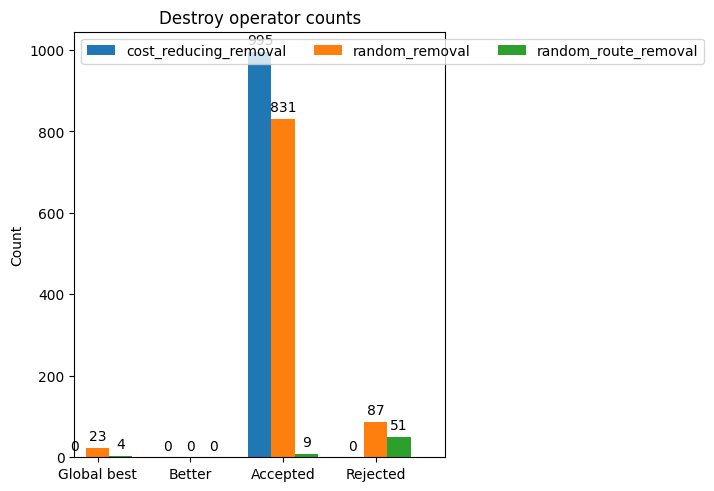

In [97]:
results_df = pd.DataFrame(result.statistics.destroy_operator_counts)
print(results_df)

reasons = ["Global best", "Better", "Accepted" , "Rejected"]
x = np.arange(len(reasons))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in results_df.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Count')
ax.set_title('Destroy operator counts')
ax.set_xticks(x + width, reasons)
ax.legend(loc='upper left', ncols=4)
ax.set_xlim(0, 4)

plt.show()

   greedy_repair
0             27
1              0
2           1835
3            138


(0.0, 4.0)

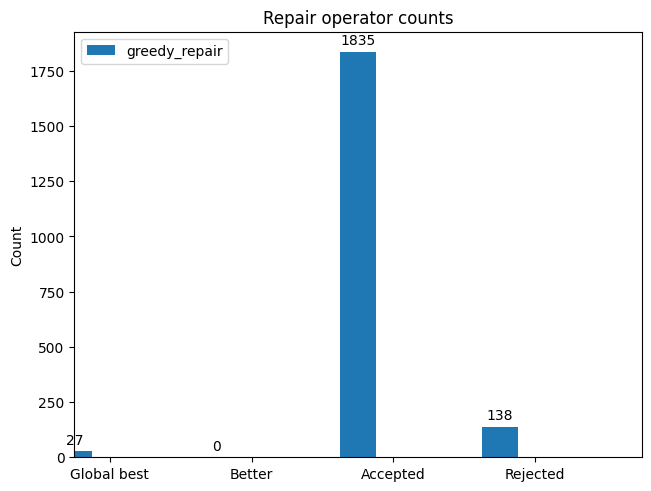

In [98]:
results_df = pd.DataFrame(result.statistics.repair_operator_counts)
print(results_df)

reasons = ["Global best", "Better", "Accepted", "Rejected"]
x = np.arange(len(reasons))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for attribute, measurement in results_df.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Count")
ax.set_title("Repair operator counts")
ax.set_xticks(x + width, reasons)
ax.legend(loc="upper left", ncols=4)
ax.set_xlim(0, 4)

In [99]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

Best heuristic objective is 60.6595643030031.


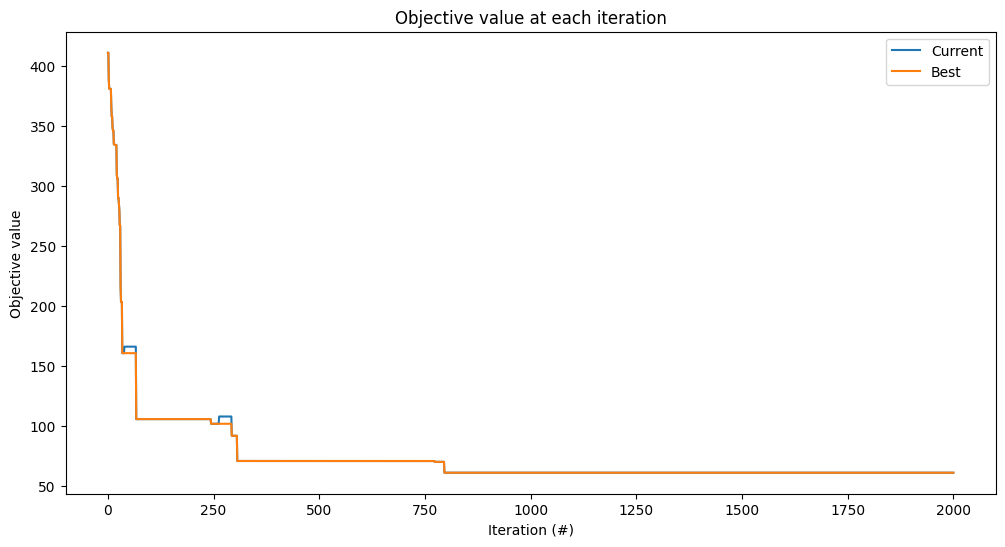

In [100]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [101]:
plot_solution(data, initial_solution, "Nearest-neighbor-solution", save=True, figsize=(8, 8))
plot_solution(data, solution, "Heuristic-solution", idx_annotations=False, save=True, figsize=(8, 8))

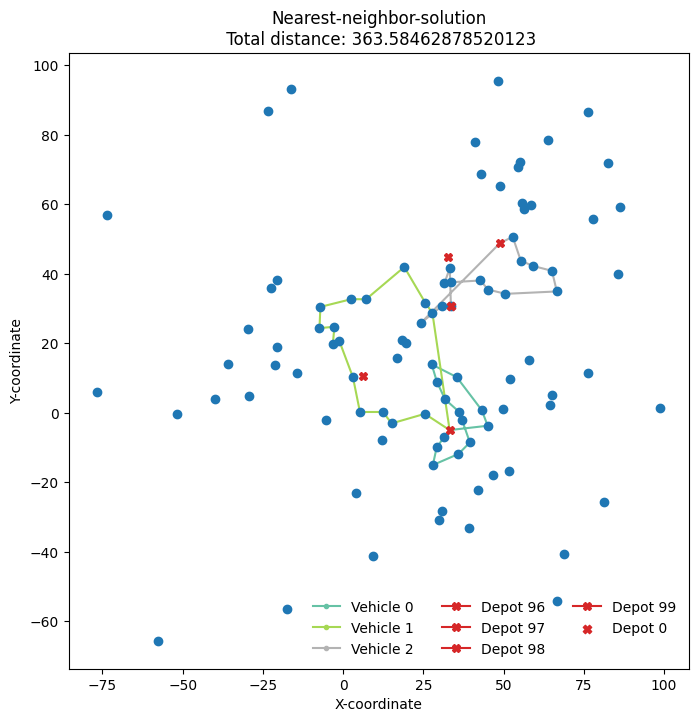

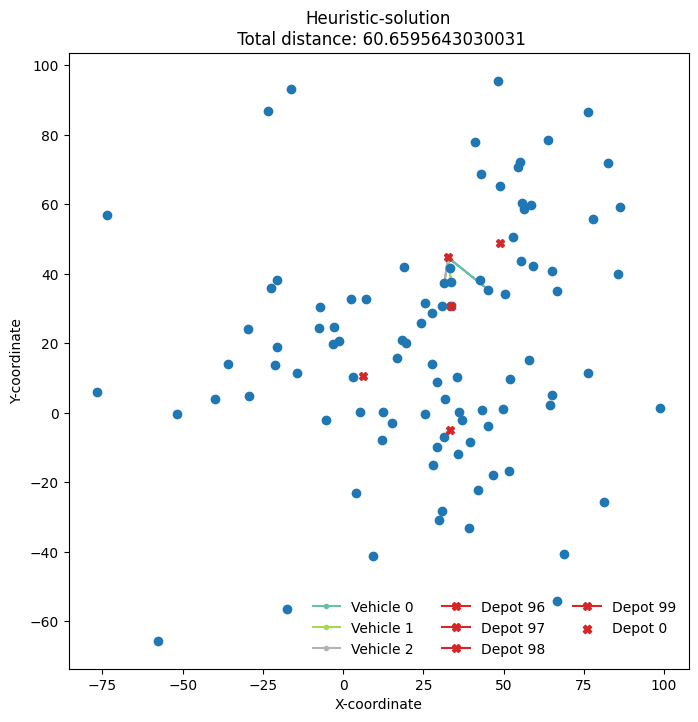

In [102]:
plot_solution(data, initial_solution, "Nearest-neighbor-solution", save=False, figsize=(8, 8))
plot_solution(data, solution, "Heuristic-solution", idx_annotations=False, save=False, figsize=(8, 8))

In [103]:
print(f"There are {len(initial_solution.routes)} routes")
served_customers = 0
for route in initial_solution.routes:
    customers = [cust for cust in route.customers_list if cust not in data["depots"]]
    served_customers += len(customers)
    print(route.customers_list)

print(f"Total number of served customers: {served_customers}")

There are 3 routes
[99, 88, 51, 60, 44, 78, 10, 27, 53, 28, 94, 56, 20, 25, 99]
[99, 57, 69, 58, 83, 80, 72, 61, 36, 43, 16, 68, 8, 93, 31, 64, 99]
[98, 95, 55, 65, 35, 70, 84, 21, 41, 87, 32, 77, 0, 46, 86, 98]
Total number of served customers: 42


In [104]:
print(f"There are {len(solution.routes)} routes")
served_customers = 0
for route in solution.routes:
    customers = [cust for cust in route.customers_list if cust not in data['depots']]
    served_customers += len(customers)
    print(route.customers_list)


print(f"Total number of served customers: {served_customers}")

There are 3 routes
[97, np.int64(21), 97]
[97, np.int64(87), 97]
[97, np.int64(32), 97]
Total number of served customers: 3
